## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
# 이미지가 28 * 28 픽셀이기 때문에, 784개의 특성을 갖고 있음
print(y.shape)

(70000, 784)
(70000,)


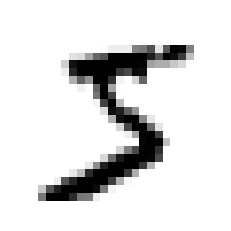

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

some_digit = X.loc[0]
some_digit_image = np.array(some_digit).reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [12]:
# 레이블은 문자열이기 때문에, 정수로 변환
print(y[0])
y = y.astype(np.uint8)

5


In [13]:
# MNIST 데이터셋은 이미 훈련 세트와 테스트 세트로 나뉘어져 있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Binary Classifier Training

In [15]:
# 분류를 위한 타깃 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=2022)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=2022)

In [17]:
sgd_clf.predict([some_digit])

c:\Users\lucky\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=2022, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9481
0.949
0.9511


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96525, 0.94745, 0.9576 ])

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    # 예측 시, 무조건 5 아님으로 예측 (False로 예측)
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])